In [29]:
from sklearn import tree
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib

Here, I'm going to attempt to build a decision tree that classifies Treg versus Tconv cells from FACS data. I've exported csv files for gated TCR&beta;+CD4+ cells that are further classified as either Foxp3- or Foxp3+

In [30]:
treg = pd.read_csv("gated_Costim_Spleen_004_034_Foxp3+.csv")
treg['Label'] = 'Treg'
tconv = pd.read_csv("gated_Costim_Spleen_004_034_Foxp3-.csv")
tconv['Label'] = 'Tconv'
d = pd.concat([treg, tconv], sort=False)

## Custom transforms

I'm going to try to implement the common FACS plot transformations (i.e. logicle) so that I can visualize my classifications in an intuitive manner within the Jupyter notebook. It turns out this is more difficult than I had anticipated (requires getting under the hood of matplotlib a bit) so this is still incomplete. To help out in the meantime, I've borrowed some code from the FlowCal package to enable logicle plots for now.

(1, 100000.0)

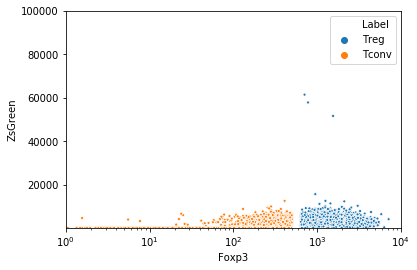

In [31]:
sns.scatterplot(data=d, x="Foxp3", y="ZsGreen", hue="Label", marker=".")
plt.xscale("log")
plt.xlim(1,1e4)
plt.ylim(1,1e5)

In [32]:
# Hyperlog

def hlog(y, b=35, d=5, r=1e6):
    result = []
    for x in y:
        if x >= 0:
            result.append(10**(d/r*x) + b * d / r * x - 1)
        else:
            result.append(-10**(-d/r*x) + b * d / r * x + 1)
    return result

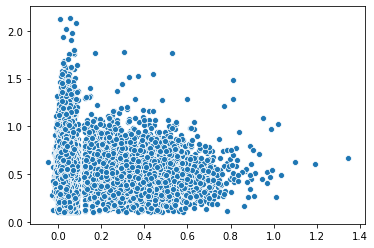

In [33]:
x = d.Foxp3
y = hlog(x)
sns.scatterplot(x=hlog(d.Foxp3), y=hlog(d.CD4))

(1, 11220.18454301963)

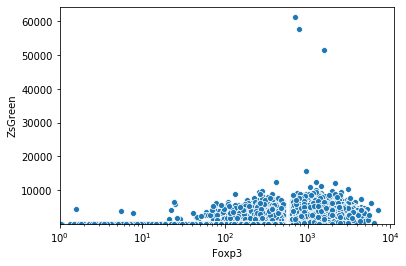

In [34]:
f, ax = plt.subplots()
sns.scatterplot(x=d.Foxp3, y=d.ZsGreen, ax=ax)
ax.set_ylim(1,None)
ax.set_xscale('log')
ax.set_xlim(1,None)

In [35]:
def logicle(x,W=0,M=4.5,T=10000):
    result = []
    p0 = 10**(W / 2.)
    # Functions to provide to the root finding algorithm
    def W_f(p):
        return 2*p / (p + 1) * np.log10(p)
    def W_root(p, W_target):
        return W_f(p) - W_target
    # Find solution
    sol = scipy.optimize.root(W_root, x0=p0, args=(W))
    # Solution should be unique
    assert sol.success
    assert len(sol.x) == 1
    p = sol.x[0]
    for X in x:
        if abs(X) >= W:
            result.append(T * 10**(-(M-W)) * (10**(X-W) - p**2 * 10**(-(X-W)/p) + p**2 - 1))
        else:
            result.append(X)
    return result

In [36]:
logicle([-3])

[-316.22744978907195]

In [37]:
W=4
p0 = 10**(W / 2.)
# Functions to provide to the root finding algorithm
def W_f(p):
    return 2*p / (p + 1) * np.log10(p)
def W_root(p, W_target):
    return W_f(p) - W_target
# Find solution
sol = scipy.optimize.root(W_root, x0=p0, args=(W))
# Solution should be unique
assert sol.success
assert len(sol.x) == 1

In [38]:
sol

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.04360964e-13])
       r: array([-0.00859545])
  status: 1
 success: True
       x: array([104.50517763])

In [39]:
sol.x[0]

104.50517762858593

## Logicle transform from FlowCal

In [40]:
import packaging.version
import matplotlib
import matplotlib.scale
import matplotlib.transforms
import matplotlib.ticker

In [41]:
try:
    import palettable
except ImportError as e:
    cmap_default = plt.get_cmap(matplotlib.rcParams['image.cmap'])
else:
    cmap_default = palettable.colorbrewer.diverging.Spectral_8_r.mpl_colormap

In [42]:
## Logicle scaling (from FlowCal)
class _InterpolatedInverseTransform(matplotlib.transforms.Transform):
    """
    Class that inverts a given transform class using interpolation.
    Parameters
    ----------
    transform : matplotlib.transforms.Transform
        Transform class to invert. It should be a monotonic transformation.
    smin : float
        Minimum value to transform.
    smax : float
        Maximum value to transform.
    resolution : int, optional
        Number of points to use to evaulate `transform`. Default is 1000.
    Methods
    -------
    transform_non_affine(x)
        Apply inverse transformation to a Nx1 numpy array.
    Notes
    -----
    Upon construction, this class generates an array of `resolution` points
    between `smin` and `smax`. Next, it evaluates the specified
    transformation on this array, and both the original and transformed
    arrays are stored. When calling ``transform_non_affine(x)``, these two
    arrays are used along with ``np.interp()`` to inverse-transform ``x``.
    Note that `smin` and `smax` are also transformed and stored. When using
    ``transform_non_affine(x)``, any values in ``x`` outside the range
    specified by `smin` and `smax` transformed are masked.
    """
    # ``input_dims``, ``output_dims``, and ``is_separable`` are required by
    # matplotlib.
    input_dims = 1
    output_dims = 1
    is_separable = True

    def __init__(self, transform, smin, smax, resolution=1000):
        # Call parent's constructor
        matplotlib.transforms.Transform.__init__(self)
        # Store transform object
        self._transform = transform

        # Generate input array
        self._s_range = np.linspace(smin, smax, resolution)
        # Evaluate provided transformation and store result
        self._x_range = transform.transform_non_affine(self._s_range)
        # Transform bounds and store
        self._xmin = transform.transform_non_affine(smin)
        self._xmax = transform.transform_non_affine(smax)
        if self._xmin > self._xmax:
            self._xmax, self._xmin = self._xmin, self._xmax

    def transform_non_affine(self, x, mask_out_of_range=True):
        """
        Transform a Nx1 numpy array.
        Parameters
        ----------
        x : array
            Data to be transformed.
        mask_out_of_range : bool, optional
            Whether to mask input values out of range.
        Return
        ------
        array or masked array
            Transformed data.
        """
        # Mask out-of-range values
        if mask_out_of_range:
            x_masked = np.ma.masked_where((x < self._xmin) | (x > self._xmax),
                                          x)
        else:
            x_masked = x
        # Calculate s and return
        return np.interp(x_masked, self._x_range, self._s_range)

    def inverted(self):
        """
        Get an object representing an inverse transformation to this class.
        Since this class implements the inverse of a given transformation,
        this function just returns the original transformation.
        Return
        ------
        matplotlib.transforms.Transform
            Object implementing the reverse transformation.
        """
        return self._transform

class _LogicleTransform(matplotlib.transforms.Transform):
    """
    Class implementing the Logicle transform, from scale to data values.
    Relevant parameters can be specified manually, or calculated from
    a given FCSData object.
    Parameters
    ----------
    T : float
        Maximum range of data values. If `data` is None, `T` defaults to
        262144. If `data` is not None, specifying `T` overrides the
        default value that would be calculated from `data`.
    M : float
        (Asymptotic) number of decades in display scale units. If `data` is
        None, `M` defaults to 4.5. If `data` is not None, specifying `M`
        overrides the default value that would be calculated from `data`.
    W : float
        Width of linear range in display scale units. If `data` is None,
        `W` defaults to 0.5. If `data` is not None, specifying `W`
        overrides the default value that would be calculated from `data`.
    data : FCSData or numpy array or list of FCSData or numpy array
        Flow cytometry data from which a set of T, M, and W parameters will
        be generated.
    channel : str or int
        Channel of `data` from which a set of T, M, and W parameters will
        be generated. `channel` should be specified if `data` is not None.
    Methods
    -------
    transform_non_affine(s)
        Apply transformation to a Nx1 numpy array.
    Notes
    -----
    Logicle scaling combines the advantages of logarithmic and linear
    scaling. It is useful when data spans several orders of magnitude
    (when logarithmic scaling would be appropriate) and a significant
    number of datapoints are negative.
    Logicle scaling is implemented using the following equation::
        x = T * 10**(-(M-W)) * (10**(s-W) \
                - (p**2)*10**(-(s-W)/p) + p**2 - 1)
    This equation transforms data ``s`` expressed in "display scale" units
    into ``x`` in "data value" units. Parameters in this equation
    correspond to the class properties. ``p`` and ``W`` are related as
    follows::
        W = 2*p * log10(p) / (p + 1)
    If a FCSData object or list of FCSData objects is specified along with
    a channel, the following default logicle parameters are used: T is
    taken from the largest ``data[i].range(channel)[1]`` or the largest
    element in ``data[i]`` if ``data[i].range()`` is not available, M is
    set to the largest of 4.5 and ``4.5 / np.log10(262144) * np.log10(T)``,
    and W is taken from ``(M - log10(T / abs(r))) / 2``, where ``r`` is the
    minimum negative event. If no negative events are present, W is set to
    zero.
    References
    ----------
    .. [1] D.R. Parks, M. Roederer, W.A. Moore, "A New Logicle Display
    Method Avoids Deceptive Effects of Logarithmic Scaling for Low Signals
    and Compensated Data," Cytometry Part A 69A:541-551, 2006, PMID
    16604519.
    """
    # ``input_dims``, ``output_dims``, and ``is_separable`` are required by
    # matplotlib.
    input_dims = 1
    output_dims = 1
    is_separable = True
    # Locator objects need this object to store the logarithm base used as an
    # attribute.
    base = 10

    def __init__(self, T=None, M=None, W=None, data=None, channel=None):
        matplotlib.transforms.Transform.__init__(self)
        # If data is included, try to obtain T, M and W from it
        if data is not None:
            if channel is None:
                raise ValueError("if data is provided, a channel should be"
                    + " specified")
            # Convert to list if necessary
            if not isinstance(data, list):
                data = [data]
            # Obtain T, M, and W if not specified
            # If elements of data have ``.range()``, use it to determine the
            # max data value. Else, use the maximum value in the array.
            if T is None:
                T = 0
                for d in data:
                    # Extract channel
                    y = d[:, channel] if d.ndim > 1 else d
                    if hasattr(y, 'range') and hasattr(y.range, '__call__'):
                        Ti = y.range(0)[1]
                    else:
                        Ti = np.max(y)
                    T = Ti if Ti > T else T
            if M is None:
                M = max(4.5, 4.5 / np.log10(262144) * np.log10(T))
            if W is None:
                W = 0
                for d in data:
                    # Extract channel
                    y = d[:, channel] if d.ndim > 1 else d
                    # If negative events are present, use minimum.
                    if np.any(y < 0):
                        r = np.min(y)
                        Wi = (M - np.log10(T / abs(r))) / 2
                        W = Wi if Wi > W else W
        else:
            # Default parameter values
            if T is None:
                T = 262144
            if M is None:
                M = 4.5
            if W is None:
                W = 0.5
        # Check that property values are valid
        if T <= 0:
            raise ValueError("T should be positive")
        if M <= 0:
            raise ValueError("M should be positive")
        if W < 0:
            raise ValueError("W should not be negative")

        # Store parameters
        self._T = T
        self._M = M
        self._W = W

        # Calculate dependent parameter p
        # It is not possible to analytically obtain ``p`` as a function of W
        # only, so ``p`` is calculated numerically using a root finding
        # algorithm. The initial estimate provided to the algorithm is taken
        # from the asymptotic behavior of the equation as ``p -> inf``. This
        # results in ``W = 2*log10(p)``.
        p0 = 10**(W / 2.)
        # Functions to provide to the root finding algorithm
        def W_f(p):
            return 2*p / (p + 1) * np.log10(p)
        def W_root(p, W_target):
            return W_f(p) - W_target
        # Find solution
        sol = scipy.optimize.root(W_root, x0=p0, args=(W))
        # Solution should be unique
        assert sol.success
        assert len(sol.x) == 1
        # Store solution
        self._p = sol.x[0]

    @property
    def T(self):
        """
        Maximum range of data.
        """
        return self._T

    @property
    def M(self):
        """
        (Asymptotic) number of decades in display scale units.
        """
        return self._M

    @property
    def W(self):
        """
        Width of linear range in display scale units.
        """
        return self._W

    def transform_non_affine(self, s):
        """
        Apply transformation to a Nx1 numpy array.
        Parameters
        ----------
        s : array
            Data to be transformed in display scale units.
        Return
        ------
        array or masked array
            Transformed data, in data value units.
        """
        T = self._T
        M = self._M
        W = self._W
        p = self._p
        # Calculate x
        return T * 10**(-(M-W)) * (10**(s-W) - (p**2)*10**(-(s-W)/p) + p**2 - 1)

    def inverted(self):
        """
        Get an object implementing the inverse transformation.
        Return
        ------
        _InterpolatedInverseTransform
            Object implementing the reverse transformation.
        """
        return _InterpolatedInverseTransform(transform=self,
                                             smin=0,
                                             smax=self._M)

class _LogicleLocator(matplotlib.ticker.Locator):
    """
    Determine the tick locations for logicle axes.
    Parameters
    ----------
    transform : _LogicleTransform
        transform object
    subs : array, optional
        Subtick values, as multiples of the main ticks. If None, do not use
        subticks.
    """

    def __init__(self, transform, subs=None):
        self._transform = transform
        if subs is None:
            self._subs = [1.0]
        else:
            self._subs = subs
        self.numticks = 15

    def set_params(self, subs=None, numticks=None):
        """
        Set parameters within this locator.
        Parameters
        ----------
        subs : array, optional
            Subtick values, as multiples of the main ticks.
        numticks : array, optional
            Number of ticks.
        """
        if numticks is not None:
            self.numticks = numticks
        if subs is not None:
            self._subs = subs

    def __call__(self):
        """
        Return the locations of the ticks.
        """
        # Note, these are untransformed coordinates
        vmin, vmax = self.axis.get_view_interval()
        return self.tick_values(vmin, vmax)

    def tick_values(self, vmin, vmax):
        """
        Get a set of tick values properly spaced for logicle axis.
        """
        # Extract base from transform object
        b = self._transform.base
        # The logicle domain is divided into two regions: A "linear" region,
        # which may include negative numbers, and a "logarithmic" region, which
        # only includes positive numbers. These two regions are separated by a
        # value t, given by the logicle equations. An illustration is given
        # below.
        #
        # -t ==0== t ========>
        #     lin       log
        #
        # vmin and vmax can be anywhere in this domain, meaning that both should
        # be greater than -t.
        #
        # The logarithmic region will only have major ticks at integral log
        # positions. The linear region will have a major tick at zero, and one
        # major tick at the largest absolute  integral log value in screen
        # inside this region. Subticks will be added at multiples of the
        # integral log positions.

        # If the linear range is too small, create new transformation object
        # with slightly wider linear range. Otherwise, the number of decades
        # below will be infinite
        if self._transform.W == 0 or \
                self._transform.M / self._transform.W > self.numticks:
            self._transform = _LogicleTransform(
                T=self._transform.T,
                M=self._transform.M,
                W=self._transform.M / self.numticks)
        # Calculate t
        t = - self._transform.transform_non_affine(0)

        # Swap vmin and vmax if necessary
        if vmax < vmin:
            vmin, vmax = vmax, vmin
        # Calculate minimum and maximum limits in scale units
        vmins = self._transform.inverted().transform_non_affine(vmin)
        vmaxs = self._transform.inverted().transform_non_affine(vmax)

        # Check whether linear or log regions are present
        has_linear = has_log = False
        if vmin <= t:
            has_linear = True
            if vmax > t:
                has_log = True
        else:
            has_log = True

        # Calculate number of ticks in linear and log regions
        # The number of ticks is distributed by the fraction that each region
        # occupies in scale units
        if has_linear:
            fraction_linear = (min(vmaxs, 2*self._transform.W) - vmins) / \
                (vmaxs - vmins)
            numticks_linear = np.round(self.numticks*fraction_linear)
        else:
            numticks_linear = 0
        if has_log:
            fraction_log = (vmaxs - max(vmins, 2*self._transform.W)) / \
                (vmaxs - vmins)
            numticks_log = np.round(self.numticks*fraction_log)
        else:
            numticks_log = 0

        # Calculate extended ranges and step size for tick location
        # Extended ranges take into account discretization.
        if has_log:
            # The logarithmic region's range will include from the decade
            # immediately below the lower end of the region to the decade
            # immediately above the upper end.
            # Note that this may extend the logarithmic region to the left.
            log_ext_range = [np.floor(np.log(max(vmin, t)) / np.log(b)),
                             np.ceil(np.log(vmax) / np.log(b))]
            # Since a major tick will be located at the lower end of the
            # extended range, make sure that it is not too close to zero.
            if vmin <= 0:
                zero_s = self._transform.inverted().\
                    transform_non_affine(0)
                min_tick_space = 1./self.numticks
                while True:
                    min_tick_s = self._transform.inverted().\
                        transform_non_affine(b**log_ext_range[0])
                    if (min_tick_s - zero_s)/(vmaxs - vmins) < min_tick_space \
                            and ((log_ext_range[0] + 1) < log_ext_range[1]):
                        log_ext_range[0] += 1
                    else:
                        break
            # Number of decades in the extended region
            log_decades = log_ext_range[1] - log_ext_range[0]
            # The step is at least one decade.
            if numticks_log > 1:
                log_step = max(np.floor(float(log_decades)/(numticks_log-1)), 1)
            else:
                log_step = 1
        else:
            # Linear region only
            linear_range = [vmin, vmax]
            # Initial step size will be one decade below the maximum whole
            # decade in the range
            linear_step = matplotlib.ticker.decade_down(
                linear_range[1] - linear_range[0], b) / b
            # Reduce the step size according to specified number of ticks
            while (linear_range[1] - linear_range[0])/linear_step > \
                    numticks_linear:
                linear_step *= b
            # Get extended range by discretizing the region limits
            vmin_ext = np.floor(linear_range[0]/linear_step)*linear_step
            vmax_ext = np.ceil(linear_range[1]/linear_step)*linear_step
            linear_range_ext = [vmin_ext, vmax_ext]

        # Calculate major tick positions
        major_ticklocs = []
        if has_log:
            # Logarithmic region present
            # If a linear region is present, add the negative of the lower limit
            # of the extended log region and zero. Then, add ticks for each
            # logarithmic step as calculated above.
            if has_linear:
                major_ticklocs.append(- b**log_ext_range[0])
                major_ticklocs.append(0)
            # Use nextafter to pick the next floating point number, and try to
            # include the upper limit in the generated range.
            major_ticklocs.extend(b ** (np.arange(
                log_ext_range[0],
                np.nextafter(log_ext_range[1], np.inf),
                log_step)))
        else:
            # Only linear region present
            # Draw ticks according to linear step calculated above.
            # Use nextafter to pick the next floating point number, and try to
            # include the upper limit in the generated range.
            major_ticklocs.extend(np.arange(
                linear_range_ext[0],
                np.nextafter(linear_range_ext[1], np.inf),
                linear_step))
        major_ticklocs = np.array(major_ticklocs)

        # Add subticks if requested
        subs = self._subs
        if (subs is not None) and (len(subs) > 1 or subs[0] != 1.0):
            ticklocs = []
            if has_log:
                # Subticks for each major tickloc present
                for major_tickloc in major_ticklocs:
                    ticklocs.extend(subs * major_tickloc)
                # Subticks from one decade below the lowest
                major_ticklocs_pos = major_ticklocs[major_ticklocs > 0]
                if len(major_ticklocs_pos):
                    tickloc_next_low = np.min(major_ticklocs_pos)/b
                    ticklocs.append(tickloc_next_low)
                    ticklocs.extend(subs * tickloc_next_low)
                # Subticks for the negative linear range
                if vmin < 0:
                    ticklocs.extend([(-ti) for ti in ticklocs if ti < -vmin ])
            else:
                ticklocs = list(major_ticklocs)
                # If zero is present, add ticks from a decade below the lowest
                if (vmin < 0) and (vmax > 0):
                    major_ticklocs_nonzero = major_ticklocs[
                        np.nonzero(major_ticklocs)]
                    tickloc_next_low = np.min(np.abs(major_ticklocs_nonzero))/b
                    ticklocs.append(tickloc_next_low)
                    ticklocs.extend(subs * tickloc_next_low)
                    ticklocs.append(-tickloc_next_low)
                    ticklocs.extend(subs * - tickloc_next_low)

        else:
            # Subticks not requested
            ticklocs = major_ticklocs

        return self.raise_if_exceeds(np.array(ticklocs))


    def view_limits(self, vmin, vmax):
        """
        Try to choose the view limits intelligently.
        """
        b = self._transform.base
        if vmax < vmin:
            vmin, vmax = vmax, vmin

        if not matplotlib.ticker.is_decade(abs(vmin), b):
            if vmin < 0:
                vmin = -matplotlib.ticker.decade_up(-vmin, b)
            else:
                vmin = matplotlib.ticker.decade_down(vmin, b)
        if not matplotlib.ticker.is_decade(abs(vmax), b):
            if vmax < 0:
                vmax = -matplotlib.ticker.decade_down(-vmax, b)
            else:
                vmax = matplotlib.ticker.decade_up(vmax, b)

        if vmin == vmax:
            if vmin < 0:
                vmin = -matplotlib.ticker.decade_up(-vmin, b)
                vmax = -matplotlib.ticker.decade_down(-vmax, b)
            else:
                vmin = matplotlib.ticker.decade_down(vmin, b)
                vmax = matplotlib.ticker.decade_up(vmax, b)
        result = matplotlib.transforms.nonsingular(vmin, vmax)
        return result

class _LogicleScale(matplotlib.scale.ScaleBase):
    """
    Class that implements the logicle axis scaling.
    To select this scale, an instruction similar to
    ``gca().set_yscale("logicle")`` should be used. Note that any keyword
    arguments passed to ``set_xscale`` and ``set_yscale`` are passed along
    to the scale's constructor.
    Parameters
    ----------
    T : float
        Maximum range of data values. If `data` is None, `T` defaults to
        262144. If `data` is not None, specifying `T` overrides the
        default value that would be calculated from `data`.
    M : float
        (Asymptotic) number of decades in display scale units. If `data` is
        None, `M` defaults to 4.5. If `data` is not None, specifying `M`
        overrides the default value that would be calculated from `data`.
    W : float
        Width of linear range in display scale units. If `data` is None,
        `W` defaults to 0.5. If `data` is not None, specifying `W`
        overrides the default value that would be calculated from `data`.
    data : FCSData or numpy array or list of FCSData or numpy array
        Flow cytometry data from which a set of T, M, and W parameters will
        be generated.
    channel : str or int
        Channel of `data` from which a set of T, M, and W parameters will
        be generated. `channel` should be specified if `data` is not None.
    """
    # String name of the scaling
    name = 'logicle'

    def __init__(self, axis, **kwargs):
#     def __init__(self, **kwargs):
        # Run parent's constructor
        matplotlib.scale.ScaleBase.__init__(self, axis)
        # Initialize and store logicle transform object
        self._transform = _LogicleTransform(**kwargs)

    def get_transform(self):
        """
        Get a new object to perform the scaling transformation.
        """
        return _InterpolatedInverseTransform(transform=self._transform,
                                             smin=0,
                                             smax=self._transform._M)

    def set_default_locators_and_formatters(self, axis):
        """
        Set up the locators and formatters for the scale.
        Parameters
        ----------
        axis: matplotlib.axis
            Axis for which to set locators and formatters.
        """
        axis.set_major_locator(_LogicleLocator(self._transform))
        axis.set_minor_locator(_LogicleLocator(self._transform,
                                               subs=np.arange(2.0, 10.)))
        axis.set_major_formatter(matplotlib.ticker.LogFormatterSciNotation(
            labelOnlyBase=True))

    def limit_range_for_scale(self, vmin, vmax, minpos):
        """
        Return minimum and maximum bounds for the logicle axis.
        Parameters
        ----------
        vmin : float
            Minimum data value.
        vmax : float
            Maximum data value.
        minpos : float
            Minimum positive value in the data. Ignored by this function.
        Return
        ------
        float
            Minimum axis bound.
        float
            Maximum axis bound.
        """
        vmin_bound = self._transform.transform_non_affine(0)
        vmax_bound = self._transform.transform_non_affine(self._transform.M)
        vmin = max(vmin, vmin_bound)
        vmax = min(vmax, vmax_bound)
        return vmin, vmax

# Register custom scales
matplotlib.scale.register_scale(_LogicleScale)


In [43]:
def hist1d(data_list,
           channel=0,
           xscale='logicle',
           bins=256,
           histtype='stepfilled',
           normed_area=False,
           normed_height=False,
           xlabel=None,
           ylabel=None,
           xlim=None,
           ylim=None,
           title=None,
           legend=False,
           legend_loc='best',
           legend_fontsize='medium',
           legend_labels=None,
           facecolor=None,
           edgecolor=None,
           savefig=None,
           **kwargs):
    """
    Plot one 1D histogram from one or more flow cytometry data sets.
    Parameters
    ----------
    data_list : FCSData or numpy array or list of FCSData or numpy array
        Flow cytometry data to plot.
    channel : int or str, optional
        Channel from where to take the events to plot. If ndim == 1,
        channel is ignored. String channel specifications are only
        supported for data types which support string-based indexing
        (e.g. FCSData).
    xscale : str, optional
        Scale of the x axis, either ``linear``, ``log``, or ``logicle``.
    bins : int or array_like, optional
        If `bins` is an integer, it specifies the number of bins to use.
        If `bins` is an array, it specifies the bin edges to use. If `bins`
        is None or an integer, `hist1d` will attempt to use
        ``data.hist_bins`` to generate the bins automatically.
    histtype : {'bar', 'barstacked', 'step', 'stepfilled'}, str, optional
        Histogram type. Directly passed to ``plt.hist``.
    normed_area : bool, optional
        Flag indicating whether to normalize the histogram such that the
        area under the curve is equal to one. The resulting plot is
        equivalent to a probability density function.
    normed_height : bool, optional
        Flag indicating whether to normalize the histogram such that the
        sum of all bins' heights is equal to one. The resulting plot is
        equivalent to a probability mass function. `normed_height` is
        ignored if `normed_area` is True.
    savefig : str, optional
        The name of the file to save the figure to. If None, do not save.
    Other parameters
    ----------------
    xlabel : str, optional
        Label to use on the x axis. If None, attempts to extract channel
        name from last data object.
    ylabel : str, optional
        Label to use on the y axis. If None and ``normed_area==True``, use
        'Probability'. If None, ``normed_area==False``, and
        ``normed_height==True``, use 'Counts (normalized)'. If None,
        ``normed_area==False``, and ``normed_height==False``, use 'Counts'.
    xlim : tuple, optional
        Limits for the x axis. If not specified and `bins` exists, use
        the lowest and highest values of `bins`.
    ylim : tuple, optional
        Limits for the y axis.
    title : str, optional
        Plot title.
    legend : bool, optional
        Flag specifying whether to include a legend. If `legend` is True,
        the legend labels will be taken from `legend_labels` if present,
        else they will be taken from ``str(data_list[i])``.
    legend_loc : str, optional
        Location of the legend.
    legend_fontsize : int or str, optional
        Font size for the legend.
    legend_labels : list, optional
        Labels to use for the legend.
    facecolor : matplotlib color or list of matplotlib colors, optional
        The histogram's facecolor. It can be a list with the same length as
        `data_list`. If `edgecolor` and `facecolor` are not specified, and
        ``histtype == 'stepfilled'``, the facecolor will be taken from the
        module-level variable `cmap_default`.
    edgecolor : matplotlib color or list of matplotlib colors, optional
        The histogram's edgecolor. It can be a list with the same length as
        `data_list`. If `edgecolor` and `facecolor` are not specified, and
        ``histtype == 'step'``, the edgecolor will be taken from the
        module-level variable `cmap_default`.
    kwargs : dict, optional
        Additional parameters passed directly to matploblib's ``hist``.
    Notes
    -----
    `hist1d` calls matplotlib's ``hist`` function for each object in
    `data_list`. `hist_type`, the type of histogram to draw, is directly
    passed to ``plt.hist``. Additional keyword arguments provided to
    `hist1d` are passed directly to ``plt.hist``.
    If `normed_area` is set to True, `hist1d` calls ``plt.hist`` with
    ``density`` (or ``normed``, if matplotlib's version is older than
    2.2.0) set to True. There is a bug in matplotlib 2.1.0 that
    produces an incorrect plot in these conditions. We do not recommend
    using matplotlib 2.1.0 if `normed_area` is expected to be used.
    """
    # Using `normed_area` with matplotlib 2.1.0 causes an incorrect plot to be
    # produced. Raise warning in these conditions.
    if normed_area and packaging.version.parse(matplotlib.__version__) \
            == packaging.version.parse('2.1.0'):
        warnings.warn("bug in matplotlib 2.1.0 will result in an incorrect plot"
            " when normed_area is set to True")

    # Convert to list if necessary
    if not isinstance(data_list, list):
        data_list = [data_list]

    # Default colors
    if histtype == 'stepfilled':
        if facecolor is None:
            facecolor = [cmap_default(i)
                         for i in np.linspace(0, 1, len(data_list))]
        if edgecolor is None:
            edgecolor = ['black']*len(data_list)
    elif histtype == 'step':
        if edgecolor is None:
            edgecolor = [cmap_default(i)
                         for i in np.linspace(0, 1, len(data_list))]

    # Convert colors to lists if necessary
    if not isinstance(edgecolor, list):
        edgecolor = [edgecolor]*len(data_list)
    if not isinstance(facecolor, list):
        facecolor = [facecolor]*len(data_list)

    # Collect scale parameters that depend on all elements in data_list
    xscale_kwargs = {}
    if xscale=='logicle':
        t = _LogicleTransform(data=data_list, channel=channel)
        xscale_kwargs['T'] = t.T
        xscale_kwargs['M'] = t.M
        xscale_kwargs['W'] = t.W

    # Iterate through data_list
    for i, data in enumerate(data_list):
        # Extract channel
        if data.ndim > 1:
            y = data[:, channel]
        else:
            y = data

        # If ``data_plot.hist_bins()`` exists, obtain bin edges from it if
        # necessary. If it does not exist, do not modify ``bins``.
        if hasattr(y, 'hist_bins') and hasattr(y.hist_bins, '__call__'):
            # If bins is None or an integer, get bin edges from
            # ``data_plot.hist_bins()``.
            if bins is None or isinstance(bins, int):
                bins = y.hist_bins(channels=0,
                                   nbins=bins,
                                   scale=xscale,
                                   **xscale_kwargs)

        # Decide whether to normalize
        if normed_height and not normed_area:
            weights = np.ones_like(y)/float(len(y))
        else:
            weights = None

        # Actually plot
        if packaging.version.parse(matplotlib.__version__) \
                >= packaging.version.parse('2.2'):
            if bins is not None:
                n, edges, patches = plt.hist(y,
                                             bins,
                                             weights=weights,
                                             density=normed_area,
                                             histtype=histtype,
                                             edgecolor=edgecolor[i],
                                             facecolor=facecolor[i],
                                             **kwargs)
            else:
                n, edges, patches = plt.hist(y,
                                             weights=weights,
                                             density=normed_area,
                                             histtype=histtype,
                                             edgecolor=edgecolor[i],
                                             facecolor=facecolor[i],
                                             **kwargs)
        else:
            if bins is not None:
                n, edges, patches = plt.hist(y,
                                             bins,
                                             weights=weights,
                                             normed=normed_area,
                                             histtype=histtype,
                                             edgecolor=edgecolor[i],
                                             facecolor=facecolor[i],
                                             **kwargs)
            else:
                n, edges, patches = plt.hist(y,
                                             weights=weights,
                                             normed=normed_area,
                                             histtype=histtype,
                                             edgecolor=edgecolor[i],
                                             facecolor=facecolor[i],
                                             **kwargs)

    # Set scale of x axis
    if xscale=='logicle':
        plt.gca().set_xscale(xscale, data=data_list, channel=channel)
    else:
        plt.gca().set_xscale(xscale)

    ###
    # Final configuration
    ###

    # x and y labels
    if xlabel is not None:
        # Highest priority is user-provided label
        plt.xlabel(xlabel)
    elif hasattr(y, 'channels'):
        # Attempt to use channel name
        plt.xlabel(y.channels[0])

    if ylabel is not None:
        # Highest priority is user-provided label
        plt.ylabel(ylabel)
    elif normed_area:
        plt.ylabel('Probability')
    elif normed_height:
        plt.ylabel('Counts (normalized)')
    else:
        # Default is "Counts"
        plt.ylabel('Counts')

    # x and y limits
    if xlim is not None:
        # Highest priority is user-provided limits
        plt.xlim(xlim)
    elif bins is not None:
        # Use bins if specified
        plt.xlim((edges[0], edges[-1]))

    if ylim is not None:
        plt.ylim(ylim)

    # Title
    if title is not None:
        plt.title(title)

    # Legend
    if legend:
        if legend_labels is None:
            legend_labels = [str(data) for data in data_list]
        plt.legend(legend_labels,
                   loc=legend_loc,
                   prop={'size': legend_fontsize})

    # Save if necessary
    if savefig is not None:
        plt.tight_layout()
        plt.savefig(savefig, dpi=savefig_dpi)
        plt.close()


/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:512: MatplotlibDeprecationWarning: 
The decade_up function was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:519: MatplotlibDeprecationWarning: 
The decade_up function was deprecated in Matplotlib 3.1 and will be removed in 3.3.


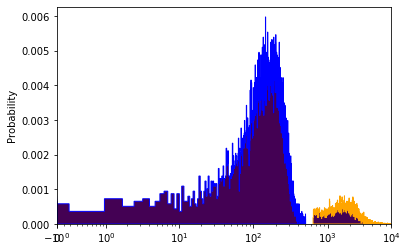

In [44]:
hist1d(data_list=d.Foxp3[d.Label == 'Tconv'], bins=1000,normed_area=True, xlim=(-10,1e5), edgecolor='blue')
hist1d(data_list=d.Foxp3[d.Label == 'Treg'], bins=1000,normed_area=True, xlim=(-100,1e5), edgecolor='orange')

In [45]:
def scatter2d(data_list, 
              channels=[0,1],
              xscale='logicle',
              yscale='logicle',
              xlabel=None,
              ylabel=None,
              xlim=None,
              ylim=None,
              title=None,
              color=None,
              savefig=None,
              **kwargs):
    """
    Plot 2D scatter plot from one or more FCSData objects or numpy arrays.
    Parameters
    ----------
    data_list : array or FCSData or list of array or list of FCSData
        Flow cytometry data to plot.
    channels : list of int, list of str
        Two channels to use for the plot.
    savefig : str, optional
        The name of the file to save the figure to. If None, do not save.
    Other parameters
    ----------------
    xscale : str, optional
        Scale of the x axis, either ``linear``, ``log``, or ``logicle``.
    yscale : str, optional
        Scale of the y axis, either ``linear``, ``log``, or ``logicle``.
    xlabel : str, optional
        Label to use on the x axis. If None, attempts to extract channel
        name from last data object.
    ylabel : str, optional
        Label to use on the y axis. If None, attempts to extract channel
        name from last data object.
    xlim : tuple, optional
        Limits for the x axis. If None, attempts to extract limits from the
        range of the last data object.
    ylim : tuple, optional
        Limits for the y axis. If None, attempts to extract limits from the
        range of the last data object.
    title : str, optional
        Plot title.
    color : matplotlib color or list of matplotlib colors, optional
        Color for the scatter plot. It can be a list with the same length
        as `data_list`. If `color` is not specified, elements from
        `data_list` are plotted with colors taken from the module-level
        variable `cmap_default`.
    kwargs : dict, optional
        Additional parameters passed directly to matploblib's ``scatter``.
    Notes
    -----
    `scatter2d` calls matplotlib's ``scatter`` function for each object in
    data_list. Additional keyword arguments provided to `scatter2d` are
    passed directly to ``plt.scatter``.
    """
    # Check appropriate number of channels
    if len(channels) != 2:
        raise ValueError('two channels need to be specified')

    # Convert to list if necessary
    if not isinstance(data_list, list):
        data_list = [data_list]

    # Default colors
    if color is None:
        color = [cmap_default(i) for i in np.linspace(0, 1, len(data_list))]

    # Convert color to list, if necessary
    if not isinstance(color, list):
       color = [color]*len(data_list)

    # Iterate through data_list
    for i, data in enumerate(data_list):
        # Get channels to plot
        data_plot = data[:, channels]
        # Make scatter plot
        plt.scatter(data_plot[:,0],
                    data_plot[:,1],
                    s=5,
                    alpha=0.25,
                    color=color[i],
                    **kwargs)

    # Set labels if specified, else try to extract channel names
    if xlabel is not None:
        plt.xlabel(xlabel)
    elif hasattr(data_plot, 'channels'):
        plt.xlabel(data_plot.channels[0])
    if ylabel is not None:
        plt.ylabel(ylabel)
    elif hasattr(data_plot, 'channels'):
        plt.ylabel(data_plot.channels[1])

    # Set scale of axes
    if xscale=='logicle':
        plt.gca().set_xscale(xscale, data=data_list, channel=channels[0])
    else:
        plt.gca().set_xscale(xscale)
    if yscale=='logicle':
        plt.gca().set_yscale(yscale, data=data_list, channel=channels[1])
    else:
        plt.gca().set_yscale(yscale)

    # Set plot limits if specified, else extract range from data_list.
    # ``.hist_bins`` with one bin works better for visualization that
    # ``.range``, because it deals with two issues. First, it automatically
    # deals with range values that are outside the domain of the current scaling
    # (e.g. when the lower range value is zero and the scaling is logarithmic).
    # Second, it takes into account events that are outside the limits specified
    # by .range (e.g. negative events will be shown with logicle scaling, even
    # when the lower range is zero).
    if xlim is None:
        xlim = [np.inf, -np.inf]
        for data in data_list:
            if hasattr(data, 'hist_bins') and \
                    hasattr(data.hist_bins, '__call__'):
                xlim_data = data.hist_bins(channels=channels[0],
                                           nbins=1,
                                           scale=xscale)
                xlim[0] = xlim_data[0] if xlim_data[0] < xlim[0] else xlim[0]
                xlim[1] = xlim_data[1] if xlim_data[1] > xlim[1] else xlim[1]
    plt.xlim(xlim)
    if ylim is None:
        ylim = [np.inf, -np.inf]
        for data in data_list:
            if hasattr(data, 'hist_bins') and \
                    hasattr(data.hist_bins, '__call__'):
                ylim_data = data.hist_bins(channels=channels[1],
                                           nbins=1,
                                           scale=yscale)
                ylim[0] = ylim_data[0] if ylim_data[0] < ylim[0] else ylim[0]
                ylim[1] = ylim_data[1] if ylim_data[1] > ylim[1] else ylim[1]
    plt.ylim(ylim)

    # Title
    if title is not None:
        plt.title(title)

    # Save if necessary
    if savefig is not None:
        plt.tight_layout()
        plt.savefig(savefig, dpi=savefig_dpi)
        plt.close()


/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:512: MatplotlibDeprecationWarning: 
The decade_up function was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:519: MatplotlibDeprecationWarning: 
The decade_up function was deprecated in Matplotlib 3.1 and will be removed in 3.3.


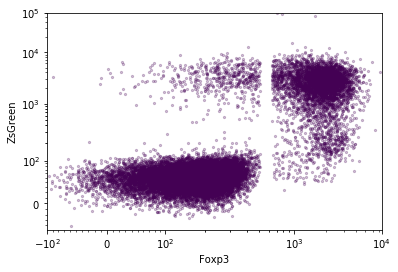

In [250]:
scatter2d(np.array(d[['Foxp3', 'ZsGreen']]), xlim=(-100,1e6), ylim=(-50,1e5), xlabel='Foxp3', ylabel='ZsGreen')

## Try building a decision tree

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

First, I need to split the data into a train and test set. This is easy enough. Also, because I used the value of Foxp3 to determine the labels, I need to remove this feature. Otherwise the classifier will use that variable alone for a perfect classification.

For now, I'll just split cells from the dame dataset. However, because I have multiple independent biological replicates, it would probably be ideal to use an entirely different sample as the test dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(d.drop(columns=['Label', 'Foxp3']), d.Label) # Drop Foxp3, because classification is perfect with it

Next, I'll try to determine the optimal value for `min_samples_leaf`, the minimum number of samples per leaf, by checking the accuracy and area under the ROC curve for various values of this variable. This is important to avoid overfitting. You can imagine that if we allow only 1 sample per leaf the model might be able learn the training data exactly.

First, we'll use the `cross_val_score` function to perform 10-fold cross validation of the model generated with variable values of `min_samples_leaf`. I should figure out how to use this procedure with the AUROC approach below.

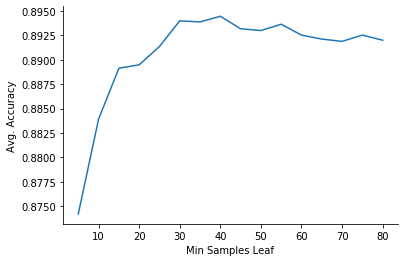

In [221]:
ns = []
accs = []
for n in range(5,81,5):
    ns.append(n)
    clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=n)
    accs.append(np.mean(cross_val_score(clf, train, train_labels, cv=10)))
    
plt.plot(ns, accs)
plt.ylabel("Avg. Accuracy")
plt.xlabel("Min Samples Leaf")
sns.despine()

Alternatively, (and probably preferentially) I can use the area under the ROC curve to determine an optimal value. There are several ways to do this but - for simplicity - I'll just evaluate the AUROC on the test set for each model trained with different values of `min_samples_leaf`.

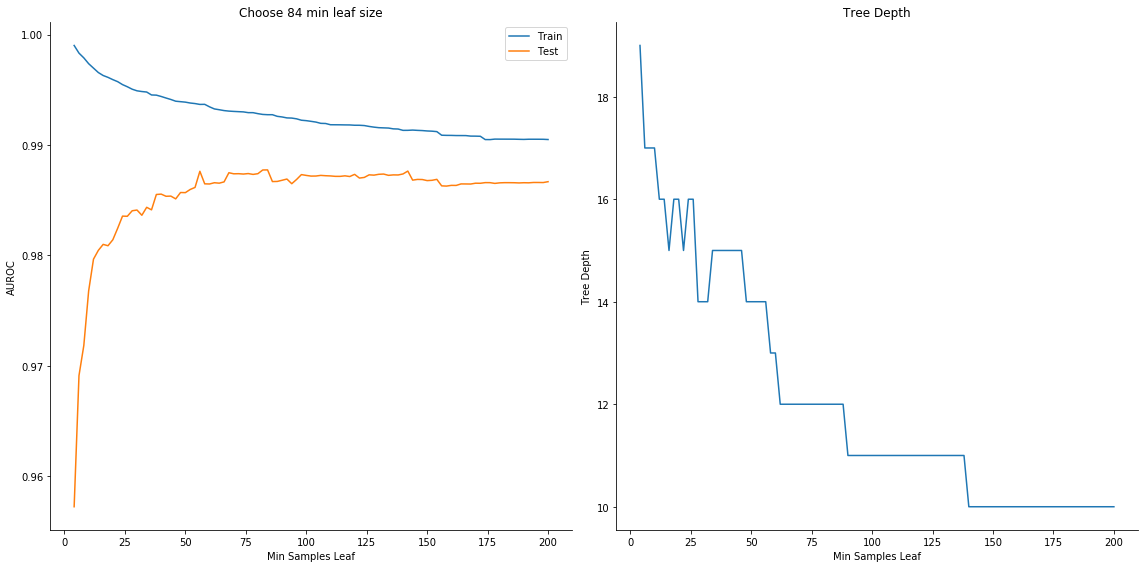

In [238]:
# Using ROC instead
f, axs = plt.subplots(1,2, figsize=(16,8), sharex=True)
ns = []
aucs_train = []
aucs_test = []
tree_depth = []
for n in range(4,201,2):
    ns.append(n)
    clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=n)
    clf = clf.fit(X_train, y_train)
    y_train_pred_prob = np.transpose(clf.predict_proba(X_train))[1]
    y_train_bin = y_train == 'Treg'
    fpr, tpr, _ = roc_curve(y_train_bin, y_train_pred_prob)
    aucs_train.append(auc(fpr, tpr))
    y_test_pred_prob = np.transpose(clf.predict_proba(X_test))[1]
    y_test_bin = y_test == 'Treg'
    fpr, tpr, _ = roc_curve(y_test_bin, y_test_pred_prob)
    aucs_test.append(auc(fpr, tpr))
    tree_depth.append(clf.get_depth())
    
axs[0].plot(ns, aucs_train, label='Train')
axs[0].plot(ns, aucs_test, label='Test')
axs[0].set_ylabel("AUROC")
axs[0].set_xlabel("Min Samples Leaf")
axs[0].legend()
optimal_leaf = ns[aucs_test.index(max(aucs_test))]
axs[0].set_title("Choose %d min leaf size" % optimal_leaf)
sns.despine()

axs[1].plot(ns, tree_depth)
axs[1].set_title("Tree Depth")
axs[1].set_ylabel("Tree Depth")
axs[1].set_xlabel("Min Samples Leaf")
sns.despine()
f.tight_layout()

This AUROC plot clearly shows that increasing the `min_samples_leaf` parameter reduces overfitting, as we see a decrease in the AUROC for the Training data and corresponding increase for the Test data, indicating that the generalizabiliy of the model increases. Above a certain value, however, the AUROC actually begins to decrease, indicating underfitting. In fact, here we observe that the maximum AUROC is achieved at `min_samples_leaf = 84`.

Interestingly, but not unexpectedly, we also observe that the model complexity (tree depth) also decreases as we increase `min_samples_leaf`, which likely also contributes to the reduction in overfitting. One interesting thing to note is that the tree depth is essentially a step function of `min_samples_leaf`, so we get the same tree depth over a wider range of minima. Considering that the AUROC curve is somewhat noisy, *I wonder if this means that setting `max_depth` would allow for better classification accuracy by allowing some leaves to have slightly less than the optimal we determined here?*

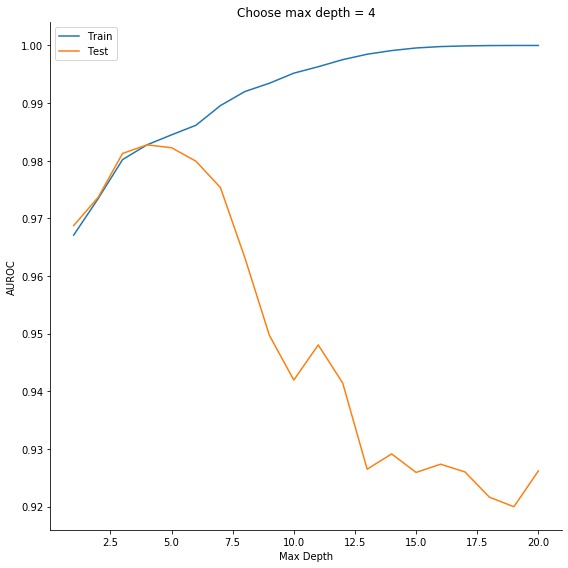

In [239]:
# Using ROC with max_depth
f, ax = plt.subplots(1, figsize=(8,8), sharex=True)
ns = []
aucs_train = []
aucs_test = []
tree_depth = []
for n in range(1,21,1):
    ns.append(n)
    clf = DecisionTreeClassifier(random_state=0, max_depth=n)
    clf = clf.fit(X_train, y_train)
    y_train_pred_prob = np.transpose(clf.predict_proba(X_train))[1]
    y_train_bin = y_train == 'Treg'
    fpr, tpr, _ = roc_curve(y_train_bin, y_train_pred_prob)
    aucs_train.append(auc(fpr, tpr))
    y_test_pred_prob = np.transpose(clf.predict_proba(X_test))[1]
    y_test_bin = y_test == 'Treg'
    fpr, tpr, _ = roc_curve(y_test_bin, y_test_pred_prob)
    aucs_test.append(auc(fpr, tpr))
    tree_depth.append(clf.get_depth())
    
ax.plot(ns, aucs_train, label='Train')
ax.plot(ns, aucs_test, label='Test')
ax.set_ylabel("AUROC")
ax.set_xlabel("Max Depth")
ax.legend()
optimal_depth = ns[aucs_test.index(max(aucs_test))]
ax.set_title("Choose max depth = %d" % optimal_depth)
sns.despine()
f.tight_layout()

So, it turns out that setting `min_samples_leaf` leads to higher AUROC than `max_depth`. Maybe because we get more discrete values?

In [240]:
clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=84)

In [241]:
clf = clf.fit(X=X_train, y=y_train)

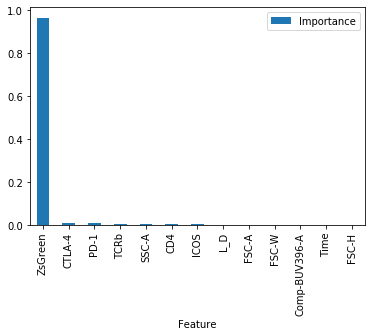

In [242]:
# Feature importances
impt = pd.DataFrame.from_dict({'Feature' : X_train.columns,
                       'Importance' : clf.feature_importances_}).set_index('Feature')
impt.sort_values(by='Importance', ascending=False).plot(kind='bar')
plt.show()

As I expected, after Foxp3 is removed the model then predominantly uses the ZsGreen reporter to divide samples into the Treg and Tconv classes, with minimal contribution from other markers.

I want to generate a classical ROC curve for this model, so I used the prediction probabilities for the Treg class along with a boolean Treg class variable as input to `roc_curve`.

In [243]:
clf.get_depth()

12

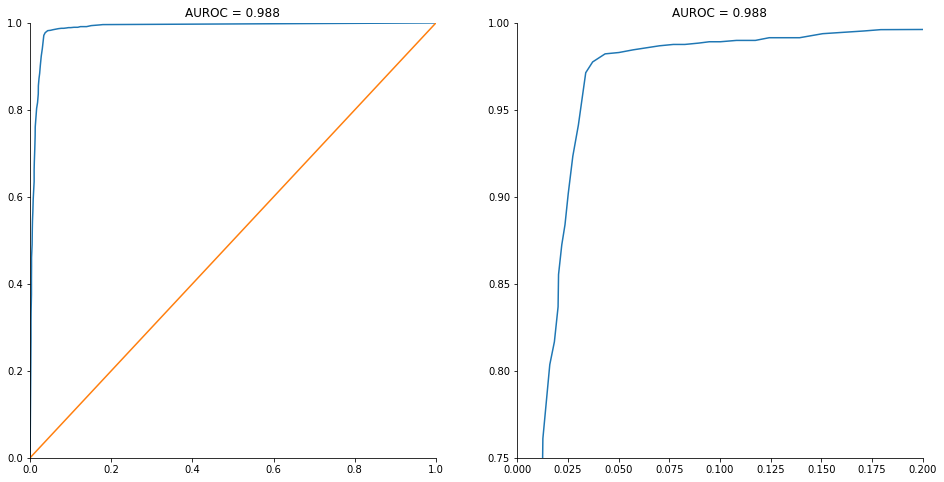

In [249]:
f, axs = plt.subplots(1,2, figsize=(16,8))
test_proba = np.transpose(clf.predict_proba(X_test))[1]

fpr, tpr, _ = roc_curve(y_test == 'Treg', test_proba)
axs[0].plot(fpr, tpr)
axs[0].plot([0,1], [0,1]) # Diagonal line
axs[0].set_xlim(0,1)
axs[0].set_ylim(0, 1)
axs[0].set_title("AUROC = %.3f" % auc(fpr, tpr))
sns.despine()

axs[1].plot(fpr, tpr)
axs[1].plot([0,1], [0,1]) # Diagonal line
axs[1].set_xlim(0,0.2)
axs[1].set_ylim(0.75, 1)
axs[1].set_title("AUROC = %.3f" % auc(fpr, tpr))
plt.show()

In [149]:
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc

In [85]:
from graphviz import Source

In [ ]:
Source(export_graphviz(clf, out_file=None, feature_names=train.columns))

## Data scaling

Decision tress are nice because they can generally perform well with unscaled data. However, for flow cytometry data, the unscaled data is unlikely to remain consistent between experiments. For this reason, I think it is wise to implement scaling prior to fitting the model, so that subsequent experiments can be classified without re-training for every experiment. The procedure below will convert the data to z-scores, which should be usable across experiments despite differences in PMT voltages because voltage should proportionally affect cells (unless squished on the axis).

In [100]:
from sklearn.preprocessing import scale

In [253]:
scaled = pd.DataFrame(scale(d.drop(columns=['Label']), axis=0), columns=d.columns[0:14])
scaled['Label'] = d.Label.to_list()

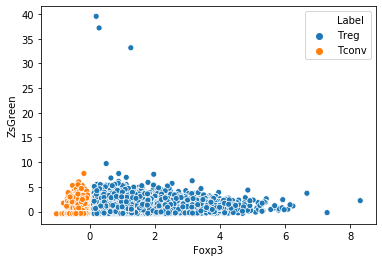

In [254]:
sns.scatterplot(data=scaled, x='Foxp3', y='ZsGreen', hue='Label')

(1, 100000.0)

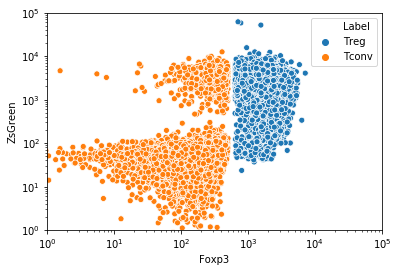

In [264]:
sns.scatterplot(data=d, x='Foxp3', y='ZsGreen', hue='Label')
plt.yscale('log')
plt.ylim((1,1e5))
plt.xscale('log')
plt.xlim(1,1e5)

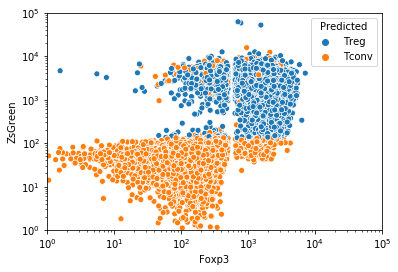

In [289]:
# Plot the predicted class labels
sns.scatterplot(data=d, x='Foxp3', y='ZsGreen', hue=clf.predict(d.drop(columns=['Label', 'Foxp3'])))
plt.yscale('log')
plt.ylim((1,1e5))
plt.xscale('log')
plt.xlim(1,1e5)
plt.legend(title='Predicted')
plt.show()

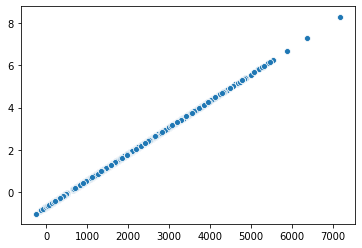

In [200]:
sns.scatterplot(x=d.Foxp3.to_list(), y=scaled.Foxp3.to_list())